# MMSegmentation Framework

## Basic immports

Things we have to take into account:
- The dataset is created in . If not, uncomment the code at the end of the next cell.

/home/alberto/anaconda3/envs/openmmlab2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.0+cu113 True
1.2.2
NVIDIA GeForce RTX 4070 Laptop GPU
47
47


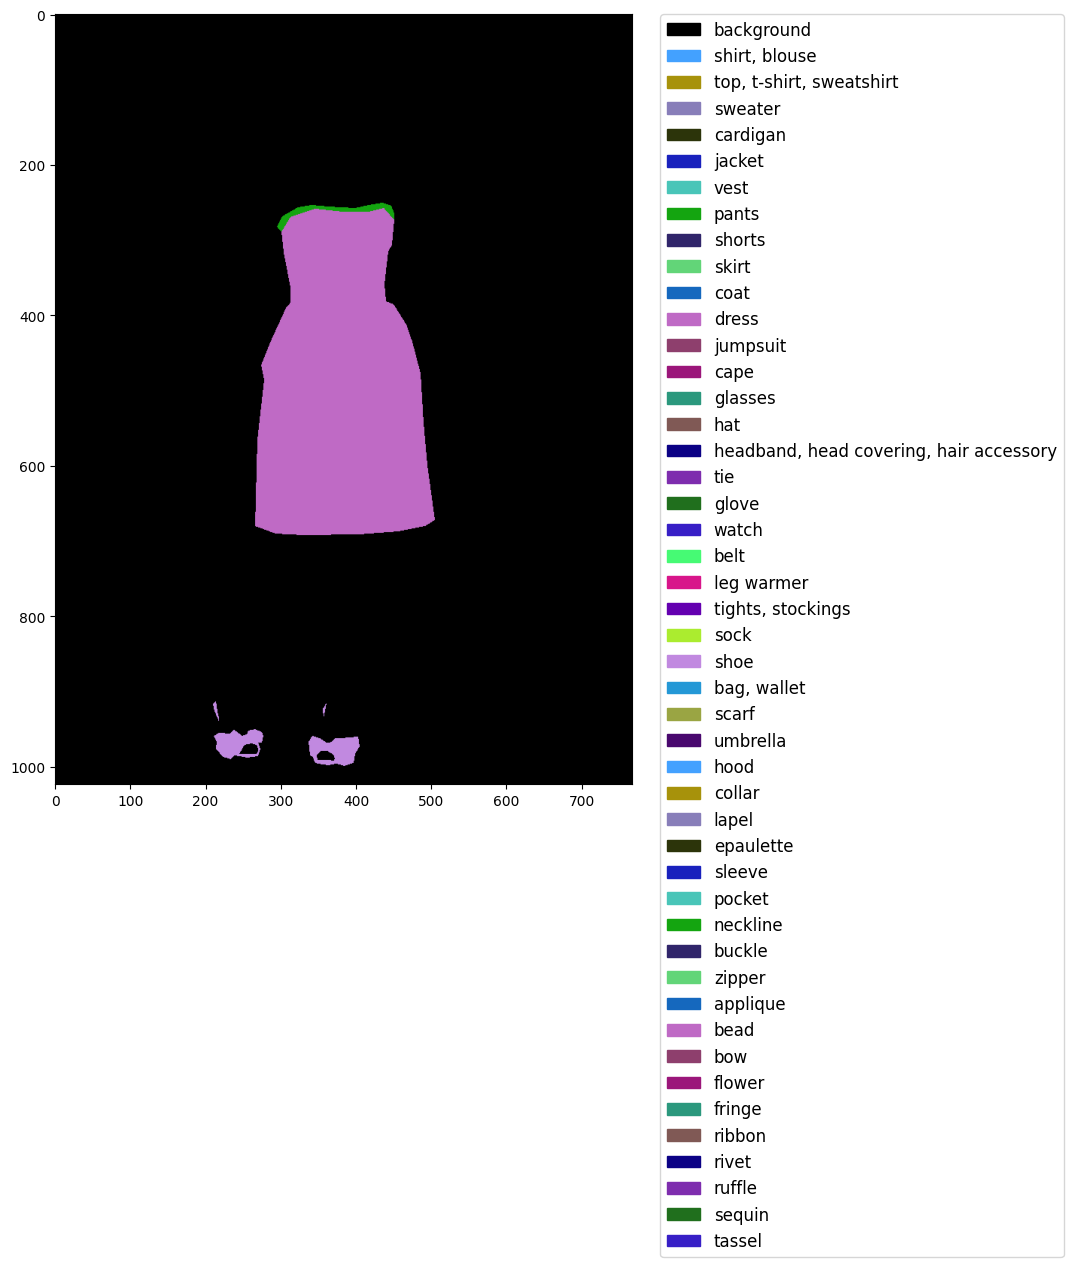

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

import numpy as np

# check cuda
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

import os
if "mmsegmentation" not in os.getcwd():
    os.chdir("mmsegmentation")

# define dataset root and directory for images and annotations
from src import config
data_root = '../' + config.dataDir
img_dir = os.path.join(data_root, 'images')
ann_dir = os.path.join(data_root, 'annotations')
# define class and palette for better visualization
classes = list(config.d_cats_bg.values())
palette = config.COLORS

print(len(palette))
print(len(classes))

assert len(palette) == len(classes)

# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(15, 10))
# im = plt.imshow(np.array(img.convert('RGB')))

mask = cv2.imread('fashion/annotations/train2020/0a0f64ffdb6aa45b0f445b217b05a6c6_seg.png', cv2.IMREAD_GRAYSCALE)

# For all the values in the mask, we will create a new mask with the same shape but with the color of the category
mask_color = np.zeros((mask.shape[0], mask.shape[1], 3))
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        mask_color[i, j] = palette[mask[i, j]]

mask_color = mask_color.astype(np.uint8)
plt.imshow(mask_color)
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(len(classes))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

# from mmseg.registry import DATASETS
# from mmseg.datasets import BaseSegDataset


# @DATASETS.register_module()
# class FashionBG(BaseSegDataset):
#   METAINFO = dict(classes = classes, palette = palette)
#   def __init__(self, **kwargs):
#     super().__init__(img_suffix='.jpg', seg_map_suffix='_seg.png', **kwargs)

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [2]:
# Download config and checkpoint files
# !mim download mmsegmentation --config pspnet_r18-d8_4xb4-80k_isaid-896x896 --dest .

In [3]:
from mmengine import Config
cfg = Config.fromfile('configs/fashion_config.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    192,
    192,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = '../datasets/fashion/'
dataset_type = 'FashionBG'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=4000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

### Train and Evaluation

Inference with trained model

In [4]:
os.getcwd()

'/home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation'

/home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: work_dirs/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth/schedule_40000/resol_192/iter_40000.pth


/home/alberto/anaconda3/envs/openmmlab2/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


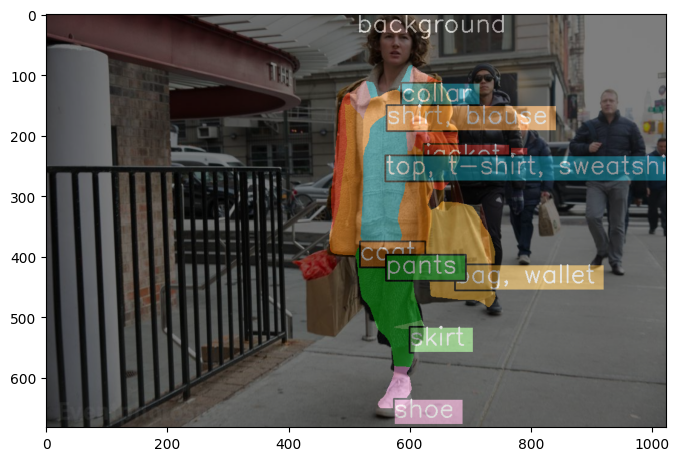

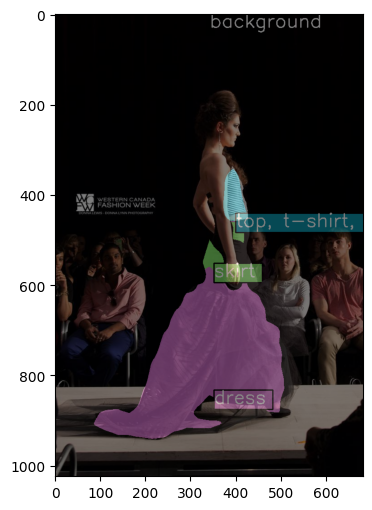

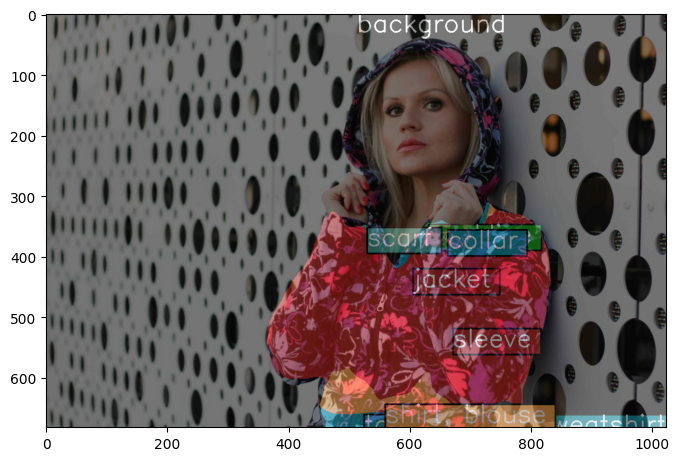

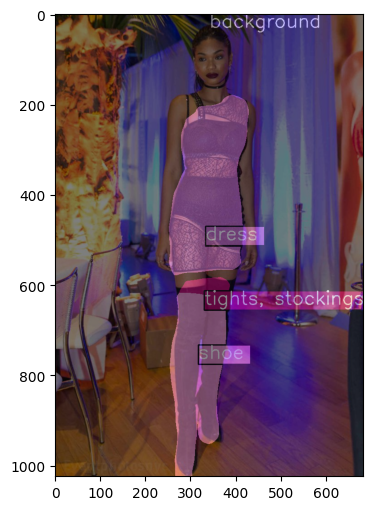

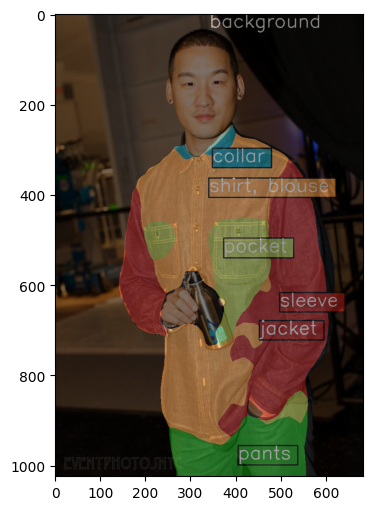

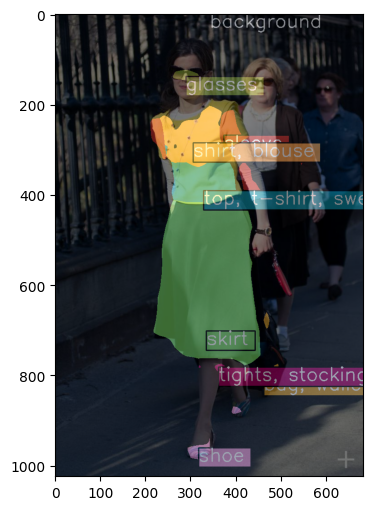

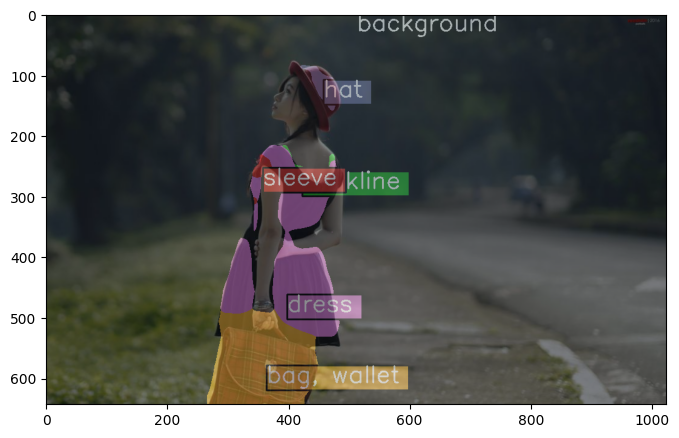

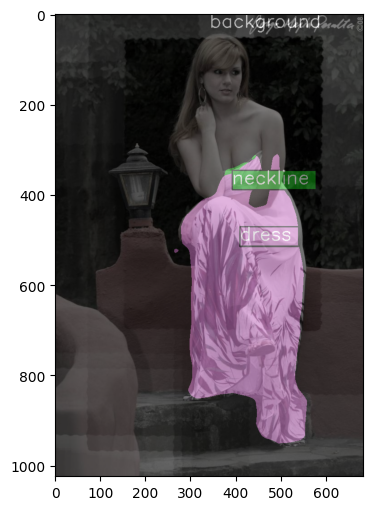

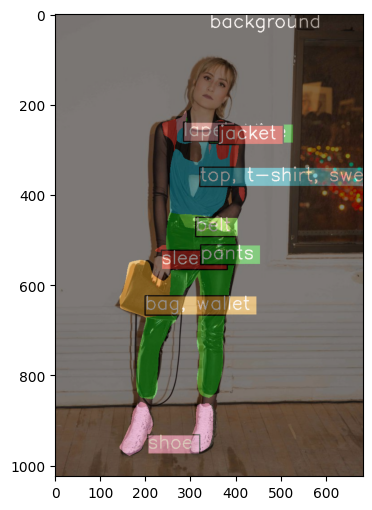

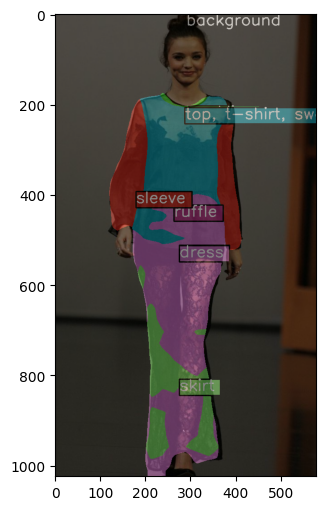

In [5]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv

# Init the model from the config and the checkpoint
checkpoint_path = 'work_dirs/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth/schedule_40000/resol_192/iter_40000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

for i in range(10):
    ls_test = os.listdir('../datasets/fashion/images/test2020')
    img = mmcv.imread(f'../datasets/fashion/images/test2020/{ls_test[i]}')
    result = inference_model(model, img)
    plt.figure(figsize=(8, 6))
    vis_result = show_result_pyplot(model, img, result)
    plt.imshow(mmcv.bgr2rgb(vis_result))
    plt.show()


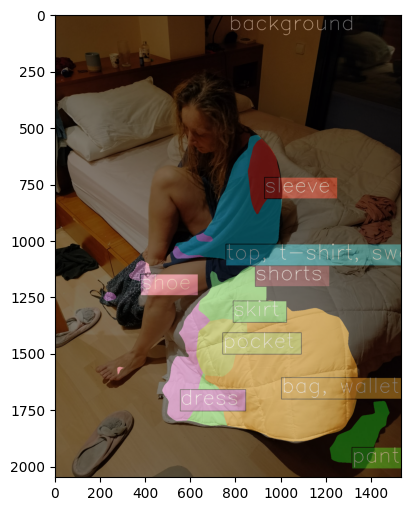

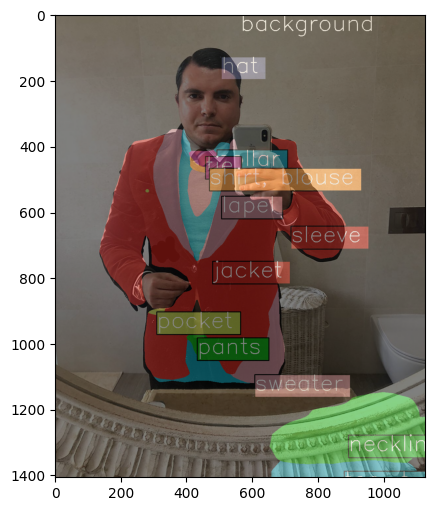

In [6]:
for i in range(2):
    ls_test = os.listdir('../datasets/others')
    img = mmcv.imread(f'../datasets/others/{ls_test[i]}')
    result = inference_model(model, img)
    plt.figure(figsize=(8, 6))
    vis_result = show_result_pyplot(model, img, result)
    plt.imshow(mmcv.bgr2rgb(vis_result))
    plt.show()
